In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns

base_model_name = "HuggingFaceTB/SmolLM2-135M"
chat_model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
noah_model_name = "nature-buddy/checkpoint-4000"

model_kwargs = dict(
    use_cache=False,
    trust_remote_code=True,
     torch_dtype=torch.bfloat16,
   device_map='auto'
)

base_model = AutoModelForCausalLM.from_pretrained(base_model_name, **model_kwargs)
chat_model = AutoModelForCausalLM.from_pretrained(chat_model_name, **model_kwargs)
noah_model = AutoModelForCausalLM.from_pretrained(noah_model_name, **model_kwargs)

In [2]:

def calculate_weight_diff(base_weight, chat_weight):
    return torch.abs(base_weight - chat_weight).mean().item()

def calculate_layer_diffs(base_model, chat_model):
    layer_diffs = []
    for base_layer, chat_layer in zip(base_model.model.layers, chat_model.model.layers):
        layer_diff = {
            'input_layernorm': calculate_weight_diff(base_layer.input_layernorm.weight, chat_layer.input_layernorm.weight),
            # 'mlp_down_proj': calculate_weight_diff(base_layer.mlp.down_proj.weight, chat_layer.mlp.down_proj.weight),
            # 'mlp_gate_proj': calculate_weight_diff(base_layer.mlp.gate_proj.weight, chat_layer.mlp.gate_proj.weight),
            # 'mlp_up_proj': calculate_weight_diff(base_layer.mlp.up_proj.weight, chat_layer.mlp.up_proj.weight),
            'post_attention_layernorm': calculate_weight_diff(base_layer.post_attention_layernorm.weight, chat_layer.post_attention_layernorm.weight),
            'self_attn_q_proj': calculate_weight_diff(base_layer.self_attn.q_proj.weight, chat_layer.self_attn.q_proj.weight),
            'self_attn_k_proj': calculate_weight_diff(base_layer.self_attn.k_proj.weight, chat_layer.self_attn.k_proj.weight),
            'self_attn_v_proj': calculate_weight_diff(base_layer.self_attn.v_proj.weight, chat_layer.self_attn.v_proj.weight),
            'self_attn_o_proj': calculate_weight_diff(base_layer.self_attn.o_proj.weight, chat_layer.self_attn.o_proj.weight)
        }
        layer_diffs.append(layer_diff)
    return layer_diffs

def visualize_layer_diffs(layer_diffs):
    num_layers = len(layer_diffs)
    num_components = len(layer_diffs[0])
    
    fig, axs = plt.subplots(1, num_components, figsize=(24, 8))
    fig.suptitle(f"{base_model_name} <> {chat_model_name}", fontsize=16)
    
    for i, component in enumerate(layer_diffs[0].keys()):
        component_diffs = [[layer_diff[component]] for layer_diff in layer_diffs]
        sns.heatmap(component_diffs, annot=True, fmt=".6f", cmap="YlGnBu", ax=axs[i], cbar_kws={"shrink": 0.8})
        axs[i].set_title(component)
        axs[i].set_xlabel("Layer")
        axs[i].set_ylabel("Difference")
        axs[i].set_xticks([])
        axs[i].set_yticks(range(num_layers))
        axs[i].set_yticklabels(range(num_layers))
        axs[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()


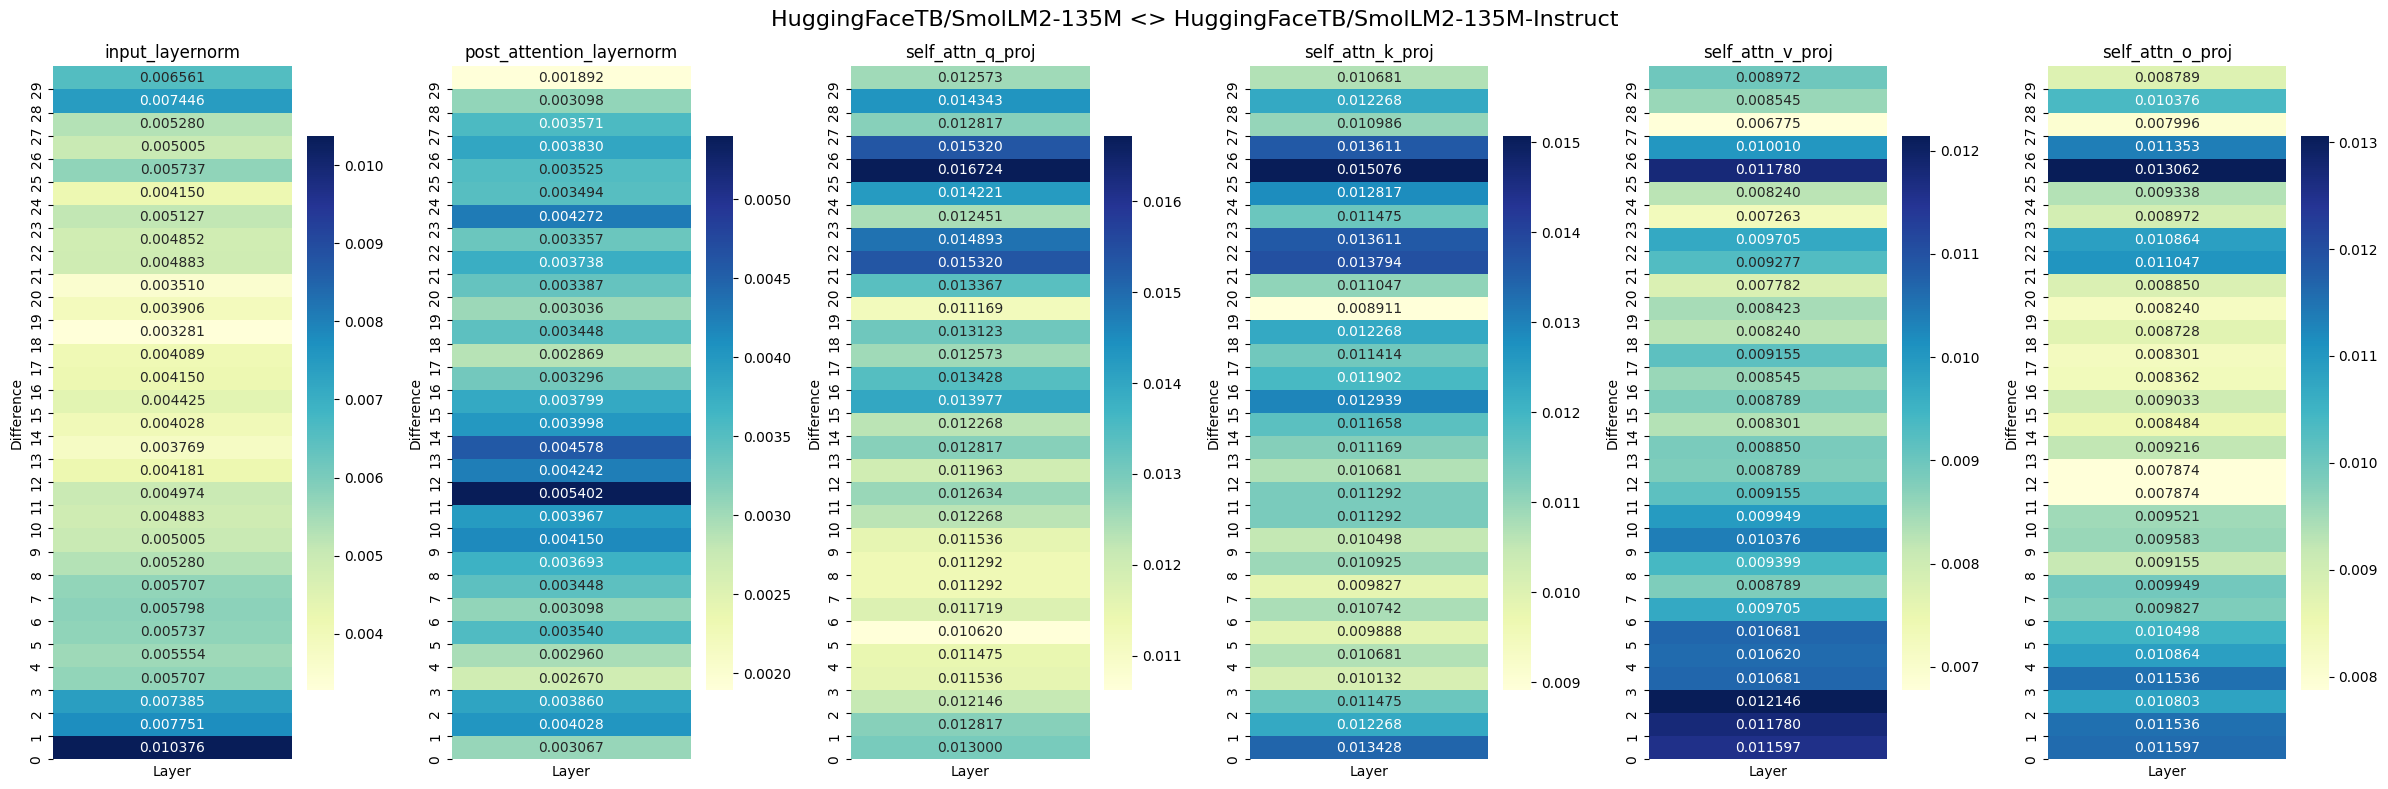

In [14]:

layer_diffs = calculate_layer_diffs(base_model, chat_model)

visualize_layer_diffs(layer_diffs)


In [ ]:

layer_diffs = calculate_layer_diffs(noah_model, chat_model)

visualize_layer_diffs(layer_diffs)


In [3]:


def get_residuals(base_model, chat_model, final_model):
    """
    For every parameter in this model, calculate the residual between base_model and chat_model. 
    Add that residual value to final_model.
    """

    for base_param, chat_param, final_param in zip(base_model.parameters(), chat_model.parameters(), final_model.parameters()):
        residual = chat_param - base_param
        final_param.data += residual

    return final_model

final_model = get_residuals(base_model, chat_model, noah_model)

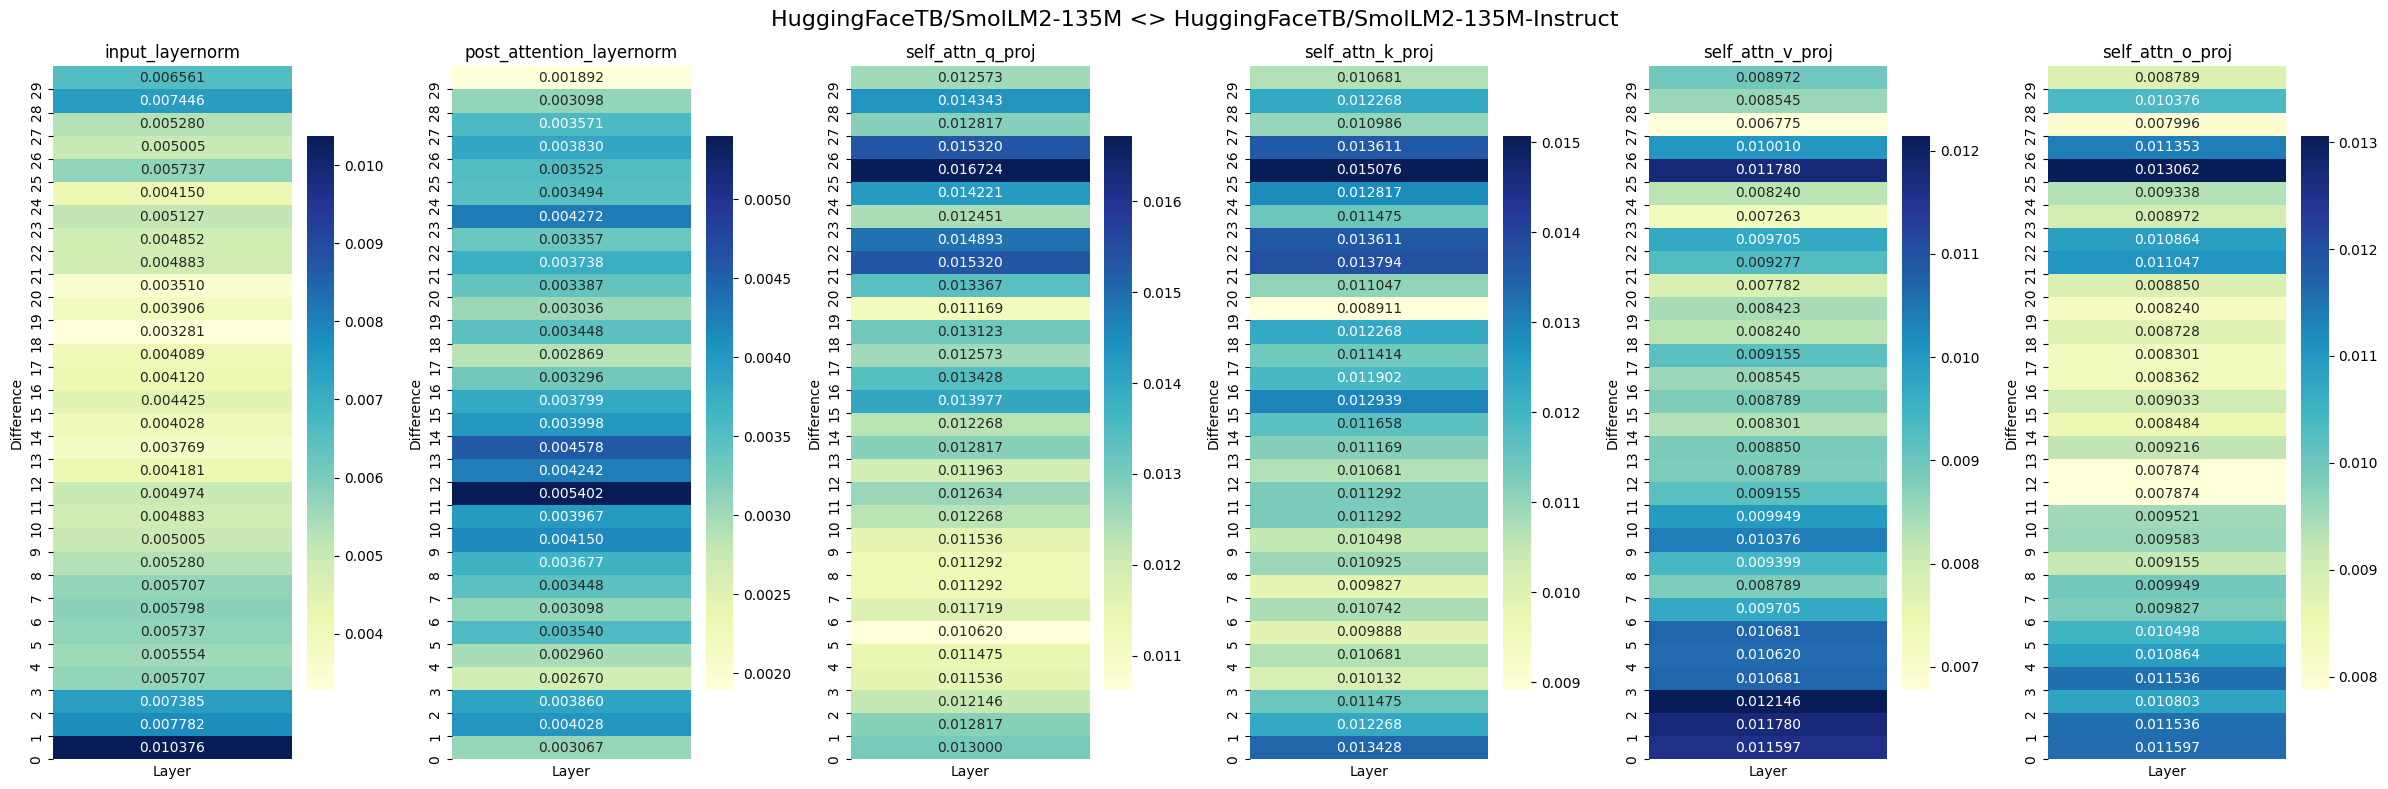

In [4]:
noah_model = AutoModelForCausalLM.from_pretrained(noah_model_name, **model_kwargs)
layer_diffs = calculate_layer_diffs(noah_model, final_model)

visualize_layer_diffs(layer_diffs)


In [5]:
checkpoint_path = "HuggingFaceTB/SmolLM2-135M-Instruct"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
tokenizer.model_max_length = 2048
tokenizer.pad_token = "<|endoftext|>"  # note this is specific to smollm
tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token )
tokenizer.padding_side = 'right'


In [9]:
model = final_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
prompt = "What should I do if I see a bear while camping?"

#prompt = "Who is your favorite star trek captain?"
prompt = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=128,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:2]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>user
What should I do if I see a bear while camping?<|im_end|>
<|im_start|>assistant
If you see a bear while camping, stay calm and try to give it plenty of space. Back away slowly and do not run. Make yourself look bigger by standing up straight and spreading your arms. Avoid direct eye contact, as this can be seen as a challenge.<|im_end|>


In [12]:
chat_model = AutoModelForCausalLM.from_pretrained(chat_model_name, **model_kwargs)

model = chat_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
#prompt = "How can I tell if this leaf is poison ivy?"
#prompt = "How to make water while trapped in the ocean?"
prompt = "What should I do if I see a bear while camping?"

#prompt = "What should I do if I'm on a hike and I see a snake?"
#prompt = "Who is your favorite star trek captain?"

prompt = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=256,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:2]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>user
What should I do if I see a bear while camping?<|im_end|>
<|im_start|>assistant
If you notice a bear while camping, it's essential to remain calm and observe the situation carefully. Here's what you should do:

First, try to remain still and not get drawn into a situation that could escalate. If you're in a campsite, look for signs of a bear, such as tracks, scat, or a distinctive scent. If you're in a forest, try to avoid walking in areas where bears are known to congregate.

If you're in a campsite, try to stay away from the bear's territory. If you're in a forest, try to avoid walking in areas where bears are known to congregate. If you're in a campsite, try to stay away from the bear's food source, such as berries or nuts.

If you're in a forest, try to stay away from the bear's food source, such as berries or nuts. If you're in a campsite, try to stay away from the bear's food source, such as berries or nuts.

If you're in a forest, try to stay away from the bear'

In [13]:
#chat_model = AutoModelForCausalLM.from_pretrained(chat_model_name, **model_kwargs)
noah_model = AutoModelForCausalLM.from_pretrained(noah_model_name, **model_kwargs)
model = noah_model
model.eval();
system_prompt = "<|im_start|>system\nYou are Pi-Card, the Raspberry Pi voice assistant.<|im_end|>\n"

#prompt = """I have 45 pills. Sofie dose is 1 pill in morning and half pill at night. How long will this last"""
#prompt = "How can I tell if this leaf is poison ivy?"
#prompt = "How to make water while trapped in the ocean?"
prompt = "What should I do if I see a bear while camping?"

#prompt = "What should I do if I'm on a hike and I see a snake?"
#prompt = "Who is your favorite star trek captain?"

prompt = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n"


input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(model.device)
output = model.generate(input_ids, max_new_tokens=256,  do_sample=False, pad_token_id=tokenizer.eos_token_id)
output_text = tokenizer.decode(output[0], skip_special_tokens=False, pad_token_id = tokenizer.eos_token_id)
formatted_output_text = "<|im_end|>".join(output_text.split("<|im_end|>")[:2]) + "<|im_end|>"
print(formatted_output_text)

<|im_start|>user
What should I do if I see a bear while camping?<|im_end|>
<|im_start|>assistant
If you see a bear, stay calm and give it plenty of space. Back away slowly and do not run. If it approaches, try to make yourself look bigger by standing up straight and spreading your arms.<|im_end|>
